In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
import re
import pickle
import time
from colorama import Fore, Back, Style

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


import urllib.request
import webbrowser

In [2]:
from nltk.corpus import stopwords
#quit_words = ['quit', 'bye', 'thanks', 'exit', 'thankyou', 'thank you', 'thanku']
# sanjay
quit_words = ['quit', 'bye', 'thanks', 'exit', 'thankyou', 'thanku', 'goodbye', 'later', 'laters', "sayonara"]

greetings = ["hello","hey","hi","hello","howareyou","bot"
                 "howsitgoing","help","ineedsomehelp","ineedhelp",
                 "hithere","hellothere","hichatbot","higreatlearning",
                 "higreatlearning","anybodythere","areyouachatbot",
                 "areyouhuman","greetings","nicetomeetyou","whatsup",
                 "goodmorning","goodafternoon","goodevening",
                 "goodnight","areyoureal","youreamachine","tellmesomething",
                 "whatcanyoudo","howcanyouhelpme","ihaveaquestion",
                 "canyouhelpme","whatsyourname","greetingsbot","morning",
                 "afternoon","hellochatbot","check","test","howdy",
                 "morning","afternoon","evening","heyman","howsyourdaygoing"
                 "itsbeenawhile","howareyoudoing","sup","whatsgoingon",
                 "howseverything","howarethings","howslife","howsyourday"
                 "goodtoseeyou","nicetoseeyou","longtimenosee",
                 "pleasedtomeetyou","itsnicetomeetyou","howhaveyoubeen",
                 "howdoyoudo","yo","heymate","whazzup","gdaymate","ok"
                 "hiya"
            ]

# root to be used as random state
root = 42

In [3]:
## Spelling correction
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big_ml.txt', encoding="utf8").read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [4]:
# Common functions definition

def cleanText(s1):
#    print("Inside cleanText for:", s1)  ##debug
    ps = PorterStemmer()
    text = s1.lower()
    text = re.sub(r'[0-9]*','',text)
    text = re.sub(r'^([a-z],[A-Z])*','',text)
    text = re.sub(r'\s\s+',' ',text)
    word_list = []
    for word in nltk.word_tokenize(text):
        
#        print("Original word:", word)  ## debug print
        word = correction(word)
#        print("corrected word:", word)  ##debug print
        if(word not in stopwords.words('english')):
            ps.stem(word)
            word_list.append(word)
    text = word_list
#    print('from clean text:', word_list)  ## debug
### Removed below line after adding code for spelling correction
#    text = [ps.stem(word) for word in nltk.word_tokenize(text) if word not in stopwords.words('english')]
    text = ' '.join(text)
#    print("Final sentence:", text)  ## debug print
#    print("Returning string from cleanText is:", text)  ##debug
    return text

# After prediction convert tag to response
def getResponse(tag):
    try:
        if(resp_dict[tag]):
            response = resp_dict[tag]
            return response
        else:
            print('Response not found.. Please try another query.')
    except:
        print('Response not found for:', tag)
        print('I will update my knowledge soon :)')

def process_response(response):
    if(response[0:4]=='Link'):
        url = response[5:]
#        webbrowser.open(url)
        print("Bot: url to open is {}".format(url))
    else:
        print("Bot: ", response)

def store_new_query(query):
#    print("Inside store_new_query function")  ##debug
    with open("non_corpus_queries.txt", "a") as f:
        str = inp_text + "\n"
        f.write(str)
#SANJAY
def clean_greeting(user_input: str):
#    print("Inside clean_greeting function:", user_input)  ##debug
    cleaned_word = cleanText(user_input)
    remove_spl_char = ''.join(e for e in cleaned_word if e.isalnum())
    return ''.join([i for i in remove_spl_char if not i.isdigit()]) 

In [5]:
# test code

st = "find about neaurel networ"
cleanText(st)

Inside cleanText for: find about neaurel networ
Original word: find
corrected word: find
Original word: about
corrected word: about
Original word: neaurel
corrected word: neural
Original word: networ
corrected word: network
from clean text: ['find', 'neural', 'network']
Returning string from cleanText is: find neural network


'find neural network'

In [6]:
df = pd.read_csv("Corpus_1.csv")
df.columns = ['query', 'response', 'tag']
df = df.dropna()


In [7]:
df.head(2)

,query,response,tag
0,What is linear regression,Link:https://en.wikipedia.org/wiki/Linear_regr...,Linear regression
1,Can you explain linear regression,Link:https://en.wikipedia.org/wiki/Linear_regr...,Linear regression


In [8]:
df['transformed_query'] = df['query'].apply(cleanText)

Inside cleanText for: What is linear regression
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
from clean text: ['linear', 'regression']
Returning string from cleanText is: linear regression
Inside cleanText for: Can you explain linear regression
Original word: can
corrected word: can
Original word: you
corrected word: you
Original word: explain
corrected word: explain
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
from clean text: ['explain', 'linear', 'regression']
Returning string from cleanText is: explain linear regression
Inside cleanText for: Please provide linear regression example
Original word: please
corrected word: please
Original word: provide
corrected word: provide
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
Original word: example
corrected 

from clean text: ['select', 'features', 'naivebayes']
Returning string from cleanText is: select features naivebayes
Inside cleanText for: how to build random forest model for classification
Original word: how
corrected word: how
Original word: to
corrected word: to
Original word: build
corrected word: build
Original word: random
corrected word: random
Original word: forest
corrected word: forest
Original word: model
corrected word: model
Original word: for
corrected word: for
Original word: classification
corrected word: classification
from clean text: ['build', 'random', 'forest', 'model', 'classification']
Returning string from cleanText is: build random forest model classification
Inside cleanText for: did not get random forest
Original word: did
corrected word: did
Original word: not
corrected word: not
Original word: get
corrected word: get
Original word: random
corrected word: random
Original word: forest
corrected word: forest
from clean text: ['get', 'random', 'forest']
Return

from clean text: ['called', 'linear', 'regression']
Returning string from cleanText is: called linear regression
Inside cleanText for: Is multiple regression linear?
Original word: is
corrected word: is
Original word: multiple
corrected word: multiple
Original word: regression
corrected word: regression
Original word: linear
corrected word: linear
Original word: ?
corrected word: a
from clean text: ['multiple', 'regression', 'linear']
Returning string from cleanText is: multiple regression linear
Inside cleanText for: What is A and B in linear regression?
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: a
corrected word: a
Original word: and
corrected word: and
Original word: b
corrected word: b
Original word: in
corrected word: in
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
Original word: ?
corrected word: a
from clean text: ['b', 'linear', 'regression']
Returning string from cleanText is

Original word: a
corrected word: a
Original word: scalar
corrected word: scalar
Original word: response
corrected word: response
Original word: and
corrected word: and
Original word: explanatory
corrected word: explanatory
Original word: variables
corrected word: variables
from clean text: ['linear', 'regression', 'established', 'relationship', 'scalar', 'response', 'explanatory', 'variables']
Returning string from cleanText is: linear regression established relationship scalar response explanatory variables
Inside cleanText for: one explanatory variable is called simple linear regression
Original word: one
corrected word: one
Original word: explanatory
corrected word: explanatory
Original word: variable
corrected word: variable
Original word: is
corrected word: is
Original word: called
corrected word: called
Original word: simple
corrected word: simple
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
from clean text: ['one', 'explanator

corrected word: exogeneity
from clean text: ['weak', 'exogeneity']
Returning string from cleanText is: weak exogeneity
Inside cleanText for: Linearity
Original word: linearity
corrected word: linearity
from clean text: ['linearity']
Returning string from cleanText is: linearity
Inside cleanText for: homoscedasticity in linear regression
Original word: homoscedasticity
corrected word: homoscedasticity
Original word: in
corrected word: in
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
from clean text: ['homoscedasticity', 'linear', 'regression']
Returning string from cleanText is: homoscedasticity linear regression
Inside cleanText for: Simple and multiple linear regression
Original word: simple
corrected word: simple
Original word: and
corrected word: and
Original word: multiple
corrected word: multiple
Original word: linear
corrected word: linear
Original word: regression
corrected word: regression
from clean text: ['simple', 'multiple

corrected word: nearest
Original word: neighbors
corrected word: neighbors
Original word: algorithm
corrected word: algorithm
from clean text: ['nearest', 'neighbors', 'algorithm']
Returning string from cleanText is: nearest neighbors algorithm
Inside cleanText for: What is Knn in machine learning?
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: knn
corrected word: knn
Original word: in
corrected word: in
Original word: machine
corrected word: machine
Original word: learning
corrected word: learning
Original word: ?
corrected word: a
from clean text: ['knn', 'machine', 'learning']
Returning string from cleanText is: knn machine learning
Inside cleanText for: What does K mean in Knn?
Original word: what
corrected word: what
Original word: does
corrected word: does
Original word: k
corrected word: k
Original word: mean
corrected word: mean
Original word: in
corrected word: in
Original word: knn
corrected word: knn
Original word: ?
corrected wo

corrected word: nearest
Original word: neighbors
corrected word: neighbors
from clean text: ['unable', 'understand', 'nearest', 'neighbors']
Returning string from cleanText is: unable understand nearest neighbors
Inside cleanText for: unable to understand k nearest neighbors
Original word: unable
corrected word: unable
Original word: to
corrected word: to
Original word: understand
corrected word: understand
Original word: k
corrected word: k
Original word: nearest
corrected word: nearest
Original word: neighbors
corrected word: neighbors
from clean text: ['unable', 'understand', 'k', 'nearest', 'neighbors']
Returning string from cleanText is: unable understand k nearest neighbors
Inside cleanText for: unable to understand k nearest neighbours
Original word: unable
corrected word: unable
Original word: to
corrected word: to
Original word: understand
corrected word: understand
Original word: k
corrected word: k
Original word: nearest
corrected word: nearest
Original word: neighbours
corr

corrected word: scikitlearn
Original word: library
corrected word: library
from clean text: ['scikitlearn', 'library']
Returning string from cleanText is: scikitlearn library
Inside cleanText for: libraries for scikit
Original word: libraries
corrected word: libraries
Original word: for
corrected word: for
Original word: scikit
corrected word: scikit
from clean text: ['libraries', 'scikit']
Returning string from cleanText is: libraries scikit
Inside cleanText for: where can i find sklearn libraries
Original word: where
corrected word: where
Original word: can
corrected word: can
Original word: i
corrected word: i
Original word: find
corrected word: find
Original word: sklearn
corrected word: sklearn
Original word: libraries
corrected word: libraries
from clean text: ['find', 'sklearn', 'libraries']
Returning string from cleanText is: find sklearn libraries
Inside cleanText for: What is a machine learning library?
Original word: what
corrected word: what
Original word: is
corrected word

Original word: is
corrected word: is
Original word: recurrent
corrected word: recurrent
Original word: neural
corrected word: neural
Original word: networks
corrected word: networks
from clean text: ['recurrent', 'neural', 'networks']
Returning string from cleanText is: recurrent neural networks
Inside cleanText for: how to prepare data for neural networks
Original word: how
corrected word: how
Original word: to
corrected word: to
Original word: prepare
corrected word: prepare
Original word: data
corrected word: data
Original word: for
corrected word: for
Original word: neural
corrected word: neural
Original word: networks
corrected word: networks
from clean text: ['prepare', 'data', 'neural', 'networks']
Returning string from cleanText is: prepare data neural networks
Inside cleanText for: how to make neural networks
Original word: how
corrected word: how
Original word: to
corrected word: to
Original word: make
corrected word: make
Original word: neural
corrected word: neural
Original

corrected word: boost
Original word: calculate
corrected word: calculate
Original word: feature
corrected word: feature
Original word: importance
corrected word: importance
from clean text: ['boost', 'calculate', 'feature', 'importance']
Returning string from cleanText is: boost calculate feature importance
Inside cleanText for: What is permutation feature importance
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: permutation
corrected word: permutation
Original word: feature
corrected word: feature
Original word: importance
corrected word: importance
from clean text: ['permutation', 'feature', 'importance']
Returning string from cleanText is: permutation feature importance
Inside cleanText for: How to choose a Feature Selection Method for Machine Learning
Original word: how
corrected word: how
Original word: to
corrected word: to
Original word: choose
corrected word: choose
Original word: a
corrected word: a
Original word: feature
corrected

Original word: do
corrected word: do
Original word: you
corrected word: you
Original word: improve
corrected word: improve
Original word: random
corrected word: random
Original word: forest
corrected word: forest
Original word: accuracy
corrected word: accuracy
from clean text: ['improve', 'random', 'forest', 'accuracy']
Returning string from cleanText is: improve random forest accuracy
Inside cleanText for: Is Random Forest linear or nonlinear
Original word: is
corrected word: is
Original word: random
corrected word: random
Original word: forest
corrected word: forest
Original word: linear
corrected word: linear
Original word: or
corrected word: or
Original word: nonlinear
corrected word: nonlinear
from clean text: ['random', 'forest', 'linear', 'nonlinear']
Returning string from cleanText is: random forest linear nonlinear
Inside cleanText for: explain random forest
Original word: explain
corrected word: explain
Original word: random
corrected word: random
Original word: forest
corre

corrected word: disadvantages
Original word: of
corrected word: of
Original word: decision
corrected word: decision
Original word: tree
corrected word: tree
from clean text: ['disadvantages', 'decision', 'tree']
Returning string from cleanText is: disadvantages decision tree
Inside cleanText for: How are decision trees trained
Original word: how
corrected word: how
Original word: are
corrected word: are
Original word: decision
corrected word: decision
Original word: trees
corrected word: trees
Original word: trained
corrected word: trained
from clean text: ['decision', 'trees', 'trained']
Returning string from cleanText is: decision trees trained
Inside cleanText for: Does decision tree given probability
Original word: does
corrected word: does
Original word: decision
corrected word: decision
Original word: tree
corrected word: tree
Original word: given
corrected word: given
Original word: probability
corrected word: probability
from clean text: ['decision', 'tree', 'given', 'probabili

corrected word: multicollinearity
Original word: affect
corrected word: affect
Original word: decision
corrected word: decision
Original word: tree
corrected word: tree
from clean text: ['multicollinearity', 'affect', 'decision', 'tree']
Returning string from cleanText is: multicollinearity affect decision tree
Inside cleanText for: decision tree tutorial
Original word: decision
corrected word: decision
Original word: tree
corrected word: tree
Original word: tutorial
corrected word: tutorial
from clean text: ['decision', 'tree', 'tutorial']
Returning string from cleanText is: decision tree tutorial
Inside cleanText for: How do you use a decision tree
Original word: how
corrected word: how
Original word: do
corrected word: do
Original word: you
corrected word: you
Original word: use
corrected word: use
Original word: a
corrected word: a
Original word: decision
corrected word: decision
Original word: tree
corrected word: tree
from clean text: ['use', 'decision', 'tree']
Returning string 

corrected word: means
Original word: clustering
corrected word: clustering
from clean text: ['explain', 'means', 'clustering']
Returning string from cleanText is: explain means clustering
Inside cleanText for: k-means clustering simple explanation
Original word: k-means
corrected word: means
Original word: clustering
corrected word: clustering
Original word: simple
corrected word: simple
Original word: explanation
corrected word: explanation
from clean text: ['means', 'clustering', 'simple', 'explanation']
Returning string from cleanText is: means clustering simple explanation
Inside cleanText for: Data clustering algorithm
Original word: data
corrected word: data
Original word: clustering
corrected word: clustering
Original word: algorithm
corrected word: algorithm
from clean text: ['data', 'clustering', 'algorithm']
Returning string from cleanText is: data clustering algorithm
Inside cleanText for: How K-means algorithm work
Original word: how
corrected word: how
Original word: k-mea

corrected word: catboost
Original word: better
corrected word: better
Original word: than
corrected word: than
Original word: xgboost
corrected word: boost
from clean text: ['catboost', 'better', 'boost']
Returning string from cleanText is: catboost better boost
Inside cleanText for: What is boosting in ML
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: boosting
corrected word: boosting
Original word: in
corrected word: in
Original word: ml
corrected word: ml
from clean text: ['boosting', 'ml']
Returning string from cleanText is: boosting ml
Inside cleanText for: What is the main objective of boosting
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: the
corrected word: the
Original word: main
corrected word: main
Original word: objective
corrected word: objective
Original word: of
corrected word: of
Original word: boosting
corrected word: boosting
from clean text: ['main', 'objective', 'boosting']


corrected word: inferential
Original word: statistics
corrected word: statistics
Original word: used
corrected word: used
Original word: for
corrected word: for
from clean text: ['inferential', 'statistics', 'used']
Returning string from cleanText is: inferential statistics used
Inside cleanText for: What is the difference between descriptive and inferential statistics
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: the
corrected word: the
Original word: difference
corrected word: difference
Original word: between
corrected word: between
Original word: descriptive
corrected word: description
Original word: and
corrected word: and
Original word: inferential
corrected word: inferential
Original word: statistics
corrected word: statistics
from clean text: ['difference', 'description', 'inferential', 'statistics']
Returning string from cleanText is: difference description inferential statistics
Inside cleanText for: What are inferential statisti

corrected word: description
Original word: statistics
corrected word: statistics
Original word: ?
corrected word: a
from clean text: ['explain', 'description', 'statistics']
Returning string from cleanText is: explain description statistics
Inside cleanText for: What is meant by descriptive statistics?
Original word: what
corrected word: what
Original word: is
corrected word: is
Original word: meant
corrected word: meant
Original word: by
corrected word: by
Original word: descriptive
corrected word: description
Original word: statistics
corrected word: statistics
Original word: ?
corrected word: a
from clean text: ['meant', 'description', 'statistics']
Returning string from cleanText is: meant description statistics
Inside cleanText for: What are some examples of descriptive statistics?
Original word: what
corrected word: what
Original word: are
corrected word: are
Original word: some
corrected word: some
Original word: examples
corrected word: examples
Original word: of
corrected word

Original word: are
corrected word: are
Original word: the
corrected word: the
Original word: different
corrected word: different
Original word: type
corrected word: type
Original word: of
corrected word: of
Original word: data
corrected word: data
Original word: visualization
corrected word: visualization
Original word: tools
corrected word: tools
from clean text: ['different', 'type', 'data', 'visualization', 'tools']
Returning string from cleanText is: different type data visualization tools
Inside cleanText for: what are the different type of bi-variate visualization graphs
Original word: what
corrected word: what
Original word: are
corrected word: are
Original word: the
corrected word: the
Original word: different
corrected word: different
Original word: type
corrected word: type
Original word: of
corrected word: of
Original word: bi-variate
corrected word: bi-variate
Original word: visualization
corrected word: visualization
Original word: graphs
corrected word: graphs
from clean 

In [9]:
# Preparing list of queries to compare to later to store new queries
query_list = df['query'].tolist()
query_list = [i.lower() for i in query_list]

In [10]:
# encoding the target column
le = LabelEncoder()
df['tag_encoded'] = le.fit_transform(df['tag'])

In [11]:
# Converting with bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2))
X = cv.fit_transform(df['transformed_query']).toarray()

y = df['tag_encoded']

In [12]:
# Creating dataframe to visualize data
temp_name = cv.get_feature_names()
temp = pd.DataFrame(X, columns=temp_name)

In [13]:
# Create dictionary for tag to response
temp = df[['tag_encoded', 'response']]
temp = temp.groupby(['tag_encoded']).max()
resp_dict = temp.to_dict()
resp_dict = resp_dict['response']

#### Test code

In [14]:
# # Test code to check accuracy
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = root)

In [15]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier


In [16]:
#mnb = MultinomialNB()
#model = mnb.fit(X_train, y_train)

# rf = RandomForestClassifier()
# model = rf.fit(X_train,y_train)

# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# model = xgb.fit(X_train, y_train)

In [17]:
# y_pred = model.predict(X_test)

In [18]:
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, y_pred)
# print(score)

#### Test code ends here

In [19]:
# Fitting naive bayes algorithm
mnb = MultinomialNB()
model = mnb.fit(X, y)

# Mohit - we are taking accuracy on data on which we have trained model
y_pred = model.predict(X)
print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model,f)

Validation Accuracy: 0.9543057996485061


In [20]:
# Xgboost predictor
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model_xg = XGBClassifier()
model_xg = model_xg.fit(X, y)
y_pred = model_xg.predict(X)

print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model_xg,f)

Validation Accuracy: 0.9420035149384886


In [21]:
# Random forest classifier

model_rf = RandomForestClassifier()
model_rf = model_rf.fit(X, y)
y_pred = model_rf.predict(X)
print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model_xg,f)

Validation Accuracy: 0.9859402460456942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Model building ends here

#### Test code starts

In [22]:
# Predict using model
def process_input(s1):
#    s1 = 'What is linear regression?'
    s1 = cleanText(s1)
    l1=[]
    l1.append(s1)
    ldf = pd.DataFrame(l1, columns= ['query'])
    return ldf

In [23]:
# Test code to be removed
ss = 'search for library'
query_df = process_input(ss)
X_test     = cv.transform(query_df['query']).toarray()
prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
print(prediction)
print(prediction_proba.max())
print(prediction_proba)
print(model.classes_)
resp       = getResponse(prediction[0])
print(resp)


Inside cleanText for: search for library
Original word: search
corrected word: search
Original word: for
corrected word: for
Original word: library
corrected word: library
from clean text: ['search', 'library']
Returning string from cleanText is: search library
[22]
0.6067727981406362
[[0.01311884 0.01390663 0.0329007  0.01073348 0.03294498 0.01380055
  0.01225172 0.03582382 0.0358888  0.01000877 0.0075599  0.03656374
  0.01412375 0.0378908  0.00753611 0.00753611 0.01013587 0.00682222
  0.00344423 0.00512488 0.00997749 0.02527948 0.6067728  0.00985432]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Sklearn


In [24]:
from matplotlib import pyplot as plt

<BarContainer object of 24 artists>

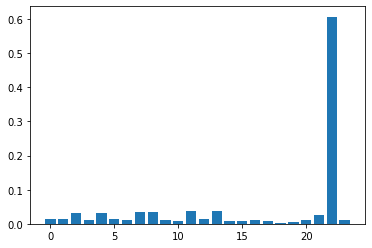

In [25]:
plt.bar(model.classes_, prediction_proba[0])

#### Testing code end here

In [26]:
# # Predict using model
# def process_input(s1):
# #    s1 = 'What is linear regression?'
#     s1 = cleanText(s1)
#     l1=[]
#     l1.append(s1)
#     ldf = pd.DataFrame(l1, columns= ['query'])
#     return ldf
    

### Start of prediction flow

#### Using pickle

In [27]:
# Trying pickle with model
pickle_in = open('./bot_model.pickle','rb')
classifier = pickle.load(pickle_in)
pickle_in.close()

### Original code to run for bot

In [28]:
# Landing message
print(Fore.RED +  "Hello. I am your machine learning assistant")
print("I can help you with your learning journey.")
print(Fore.CYAN + "You can ask me questions around algorithms and learn new stuff!!")
print(Style.RESET_ALL)
time.sleep(4)

# Get input from user
inp_text=''
while(inp_text != 'quit'):
    inp_text = input('User: ')
    
### Sanjay
    if (clean_greeting(inp_text) in quit_words):
        inp_text = 'quit'
#    print("After checking quit words", inp_text)  ##debug

### Sanjay
    if (clean_greeting(inp_text) in greetings):
        inp_text = 'greeting'
#    print("After checking greeting words:", inp_text)  ##debug
        
    if(inp_text != 'quit'):
        if(inp_text != 'greeting'):
            if(inp_text.lower() not in query_list):
                store_new_query(inp_text)
            query_df   = process_input(inp_text)
            print("Input for model:", query_df)
            X_test     = cv.transform(query_df['query']).toarray()
            prediction = classifier.predict(X_test)
            max_probab = classifier.predict_proba(X_test).max()
            print("predicted value {} with probability {}".format(prediction, max_probab))
            if (max_probab > .80):
                resp       = getResponse(prediction[0])
                process_response(resp)
            else:
                print("Sorry I am currently not trained for this question.")
        else:
            print("Hello! how can I help you ?")
    else:
        print("Thanks. See you again")

Hello. I am your machine learning assistant
I can help you with your learning journey.
You can ask me questions around algorithms and learn new stuff!!

User: helo
Inside clean_greeting function: helo
Inside cleanText for: helo
Original word: helo
corrected word: help
from clean text: ['help']
Returning string from cleanText is: help
After checking quit words helo
Inside clean_greeting function: helo
Inside cleanText for: helo
Original word: helo
corrected word: help
from clean text: ['help']
Returning string from cleanText is: help
After checking greeting words: greeting
Hello! how can I help you ?
User: ok
Inside clean_greeting function: ok
Inside cleanText for: ok
Original word: ok
corrected word: of
from clean text: []
Returning string from cleanText is: 
After checking quit words ok
Inside clean_greeting function: ok
Inside cleanText for: ok
Original word: ok
corrected word: of
from clean text: []
Returning string from cleanText is: 
After checking greeting words: ok
Inside store_

In [29]:
# In case of bbye cleanText is returning empty string